classes : ['01011001', '04017001', '06012004', '07014001', '11013007', '12011008']
label_idx : 0
class_name : 01011001

0: 640x640 1 01011001, 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 33.0ms
Speed: 3.0ms preprocess, 33.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 35.0ms
Speed: 3.0ms preprocess, 35.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3,

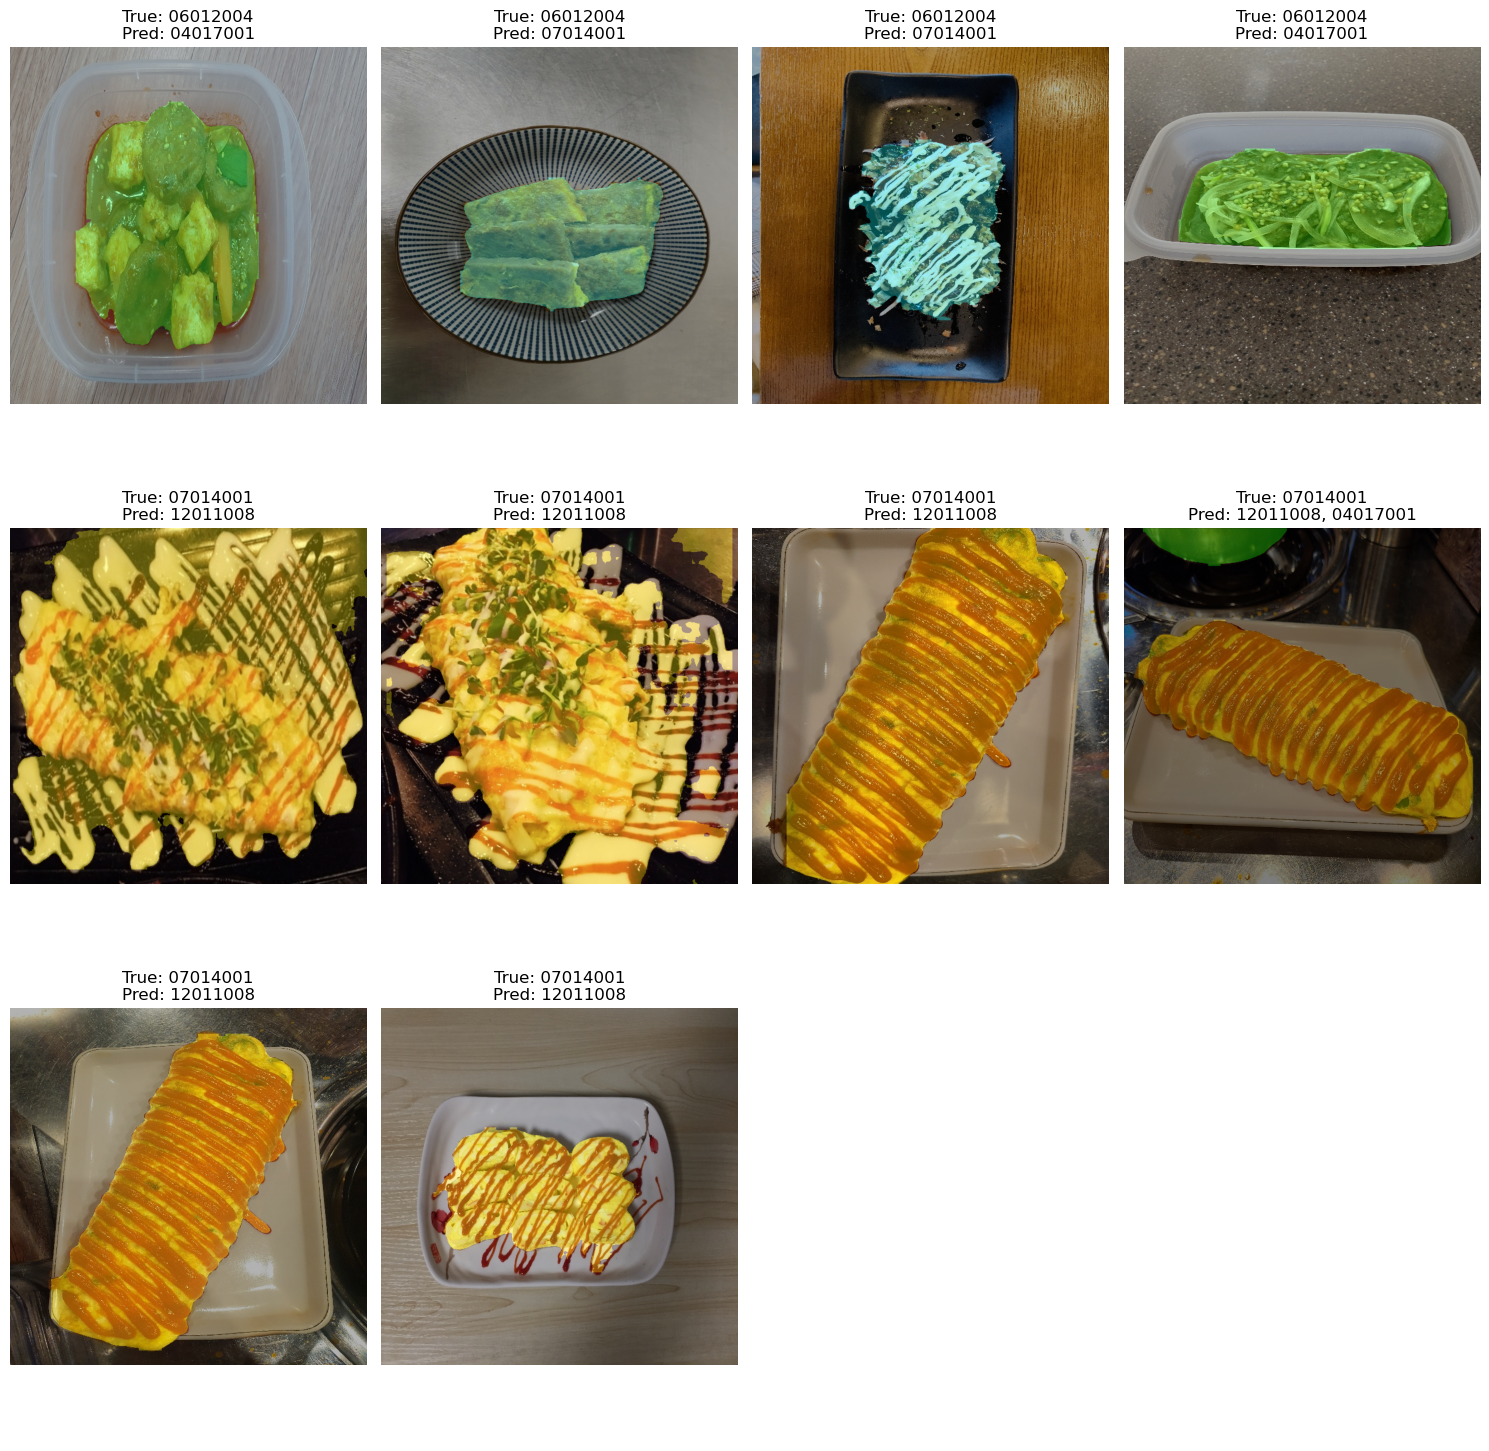

10
잘못 분류된 이미지 개수
06012004 : 3
07014001 : 5
mis_counts : {'06012004': 3, '07014001': 5}


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# 모델 경로 및 validation 데이터 경로
model_path = 'best_pt/best.pt'  # 학습된 모델 파일
valid_folder = 'C:/Users/Sesame/food_yolo_detection/1st_seg_data_test_241121/valid'  # Validation 데이터 상위 폴더
classes = sorted(os.listdir(valid_folder))  # 클래스 폴더 이름으로 라벨 추출(valid_folder안에 폴더명을 정렬한 뒤 리스트로 반환)


# 클래스별 색상 정의 (6개 클래스)
colors = [
    (255, 0, 0),   # Class 0 - Red
    (0, 255, 0),   # Class 1 - Green
    (0, 0, 255),   # Class 2 - Blue
    (255, 255, 0), # Class 3 - Cyan
    (255, 0, 255), # Class 4 - Magenta
    (0, 255, 255)  # Class 5 - Yellow
]


# 모델 로드
model = YOLO(model_path)

# 잘못 분류된 이미지 저장 리스트
misclassified_images = []
# 잘못 분류된 이미지 개수 저장할 딕셔너리
misclassified_counts = {}   # key : class_name / value : count


# Validation 데이터 처리
# 클래스 리스트를 순회하면서 idx번호와 classname을 가져옴
for label_idx, class_name in enumerate(classes): 
    print(f'classes : {classes}')   
    print(f'label_idx : {label_idx}')
    print(f'class_name : {class_name}')

    # classes : ['01011001', '04017001', '06012004', '07014001', '11013007', '12011008']
    # label_idx : 0
    # class_name : 01011001

    # 클래스별 경로설정 : 
    class_image_folder = os.path.join(valid_folder, class_name, 'images')
    if not os.path.exists(class_image_folder):
        continue

    image_files = [f for f in os.listdir(class_image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # 이미지 로드 및 모델 예측
        image_path = os.path.join(class_image_folder, image_file)
        image = cv2.imread(image_path)

        results = model(image)

        # Segmentation 마스크 처리
        if results[0].masks is not None:    # segmentation 마스크 결과가 있는지 확인
            masks = results[0].masks.data.cpu().numpy()  # (N, H, W) 형태의 binary masks
            boxes = results[0].boxes  # 바운딩 박스 정보 (클래스 ID 포함)
            cls_ids = []  # 클래스 ID를 저장할 리스트

            for box in boxes:
                cls_id = int(box.cls.item())  # 각 박스의 클래스 ID 추출
                cls_ids.append(cls_id)        # 추출한 클래스 ID를 리스트에 추가

            # 각 마스크를 이미지에 overlay
            if label_idx not in cls_ids:
                for mask, cls_id in zip(masks, cls_ids):
                    mask = (mask * 255).astype(np.uint8)  # 0~1 스케일을 0~255로 변환
                    # color = colors.get(int(cls_id), (255, 255, 255))  # 클래스별 색상 선택, 기본값 흰색
                    if int(cls_id) < len(colors):
                        color = colors[int(cls_id)]
                    else: 
                        color = (255,255,255)
                    # 색상 마스크 생성
                    colored_mask = np.zeros_like(image, dtype=np.uint8)
                    colored_mask[mask > 0] = color  # 마스크가 있는 영역에만 색상 적용

                    # 원본 이미지와 합성
                    image = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)
        
        # 모델 예측값
        pred_classes = []
        for box in results[0].boxes:
            pred_class = int(box.cls.item())
            pred_classes.append(pred_class)
       
        # 예측값이 라벨값과 다른 경우 저장
        if label_idx not in pred_classes:
            misclassified_images.append((image, class_name, pred_classes))
            if class_name in misclassified_counts:
                misclassified_counts[class_name] += 1  # 클래스별 카운트 증가
            else:
                misclassified_counts[class_name] = 1 # 해당 키가 딕셔너리에 없다면 1로 초기화
            

# 잘못 분류된 이미지 시각화
def plot_misclassified(images_with_labels):
    """잘못 분류된 이미지를 n행 × n열 그리드로 시각화"""
    total_images = len(images_with_labels)
    # print(f'잘못된거 몇개인지 확인 : 함수안에서 {total_images}')
    cols = 4  # 한 줄에 표시할 이미지 수
    rows = (total_images // cols) + 1 if total_images % cols != 0 else total_images // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, (img, true_label, pred_labels) in enumerate(images_with_labels):
        ax = axes.flatten()[i] if i < rows * cols else None
        if ax:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            pred_text = ', '.join(classes[p] for p in pred_labels)
            ax.set_title(f"True: {true_label}\nPred: {pred_text}")
            ax.axis('off')
    # 남은 빈 칸은 비활성화
    for j in range(i + 1, rows * cols):
        axes.flatten()[j].axis('off')
    plt.tight_layout()
    plt.show()

# 테스트 실행
if len(misclassified_images) > 0:
    plot_misclassified(misclassified_images)
else:
    print("모든 Validation 데이터가 올바르게 분류되었습니다.")


# 잘못 분류된 전체 이미지 갯수 출력하기 
print(len(misclassified_images))
# 클래스를 잘못 분류한 이미지 갯수 출력 
print('잘못 분류된 이미지 개수')


# 잘못 분류된 이미지 갯수 확인해보기(클래스별/전체 둘다)
for class_name, count in misclassified_counts.items():
    # print("여기 들어오니???") # misclassified_counts가 빈 딕셔너리인 경우 for 코드 실행불가
    # print(count)
    print(f'{class_name} : {count}')
print(f'mis_counts : {misclassified_counts}')
